# Synthetic Control Method
Causal analysis of the brexit impact on GDP/capita in UK

## Set up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (check_X_y, check_array, check_is_fitted)
import cvxpy as cp

# Clean

In [2]:
df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)
df.shape

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
C:\Users\guill\AppData\Local\Temp\ipykernel_26968\2777245802.py:1: SyntaxWarning: invalid escape sequence '\g'
  df = pd.read_csv('assets\gdp_per_capita.csv', sep=',', header=2)


(266, 69)

In [3]:
# drop colukmns Country Code
df = df.drop(['Country Code', "Indicator Name", "Indicator Code", "Unnamed: 68"], axis=1)
df.head(2)

,Country Name,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36763.209005,37231.918495,37444.441094,38697.949507,40379.293724,40124.757998,30437.202516,38226.146157,45236.021214,NaN
1,Africa Eastern and Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3473.843253,3502.296662,3595.841041,3640.628582,3695.386884,3783.518751,3666.871961,3967.400629,4294.025281,4459.764134


In [4]:
#only select OCDE countries
lst_ocde = oecd_countries = [
    'Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Colombia', 'Costa Rica',
    'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
    'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Latvia',
    'Lithuania', 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway',
    'Poland', 'Portugal', 'Slovak Republic', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
    'United Kingdom', 'United States'
]

df = df[df['Country Name'].isin(lst_ocde)]
df.shape

(35, 65)

<Axes: ylabel='Country Name'>

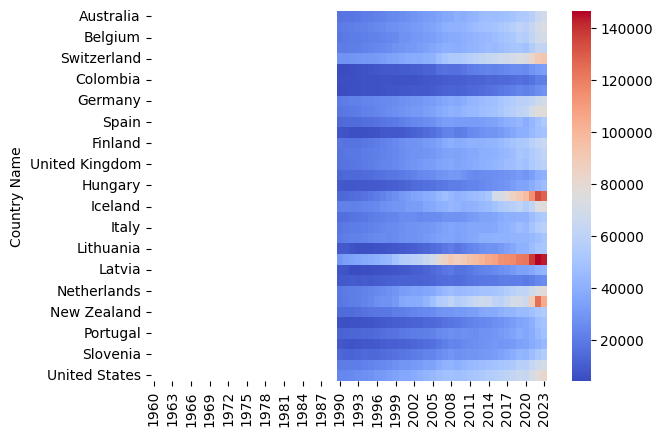

In [5]:
#plot an heatmap of all value
df = df.set_index("Country Name")
sns.heatmap(df, annot=False, cmap='coolwarm', vmax=None, vmin=None)

In [6]:
#drop all columns before 1990
df = df.drop(df.columns[0:31], axis=1)
#no NaN

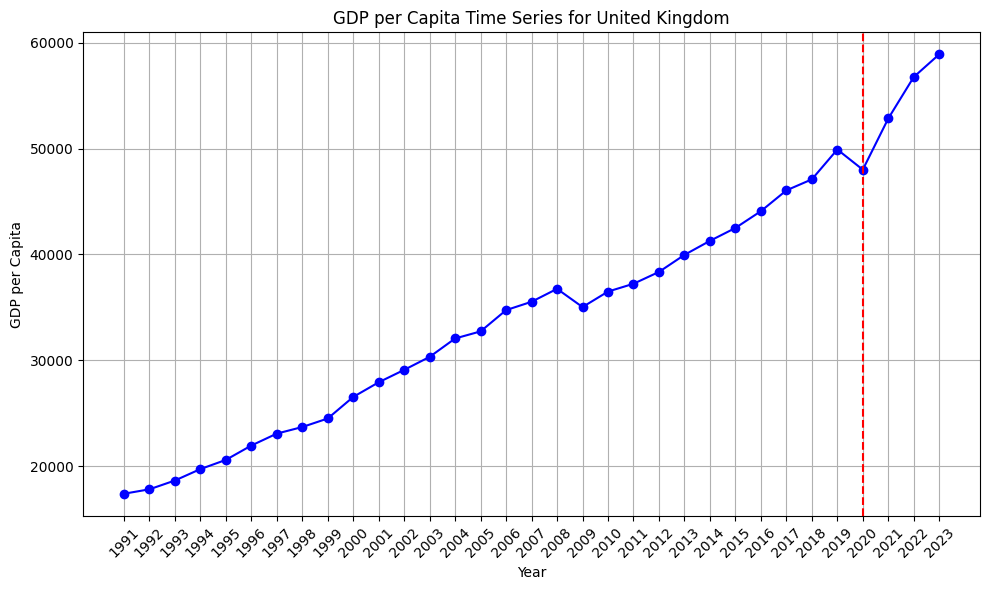

In [7]:
# Select the GDP data for the United Kingdom
uk_gdp = df.loc['United Kingdom']

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(uk_gdp.index, uk_gdp.values, marker='o', linestyle='-', color='b')
plt.title('GDP per Capita Time Series for United Kingdom')
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical line for Brexit (January 31, 2020)
plt.axvline(x='2020', color='r', linestyle='--', label='Brexit')
# Show the plot
plt.show()

# Synthetic Control Method
it should be a matrix like $ 
\begin{bmatrix}
y\_pre\_co & y\_pre\_tr \\  
y\_post\_co & y\_post\_tr \\
\end{bmatrix} $

In [8]:
def reshape_df(df: pd.DataFrame, treated: str, treatment_year: int) -> pd.DataFrame:
    """Input df should be observations X times matrix and observations should be the indexes"""
    #inverse column and rows
    df = df.transpose()

    df.index = df.index.astype(int)
    y_tr = df[treated]
    y_co = df = df.drop(columns=treated)
    y_pre_tr = y_tr[y_tr.index < treatment_year].to_frame()
    y_pre_co = y_co[y_co.index < treatment_year]
    y_post_tr = y_tr[y_tr.index >= treatment_year].to_frame()
    y_post_co = y_co[y_co.index >= treatment_year]



    return y_pre_tr, y_pre_co, y_post_tr, y_post_co

In [9]:
y_pre_tr, y_pre_co, y_post_tr, y_post_co = reshape_df(df=df, treated="United Kingdom", treatment_year=2020)

In [10]:
class SyntheticControl():
    def __init__(self,):
        pass
    def fit(self, y_pre_co, y_pre_tr):

       y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)

       w = cp.Variable(y_pre_co.shape[1])

       objective = cp.Minimize(cp.sum_squares(y_pre_co@w - y_pre_tr))
       constraints = [cp.sum(w) == 1, w >= 0]

       problem = cp.Problem(objective, constraints)

       self.loss_ = problem.solve()
       self.w_ = w.value

       self.is_fitted_ = True
       return self
    
    def predict(self, y_co):

        check_is_fitted(self)
        y_co = check_array(y_co)
        return y_co @ self.w_

In [11]:
model = SyntheticControl()
model.fit(y_pre_co=y_pre_co, y_pre_tr=y_pre_tr.mean(axis=1))

model.w_.round(3)

array([ 0.043, -0.   ,  0.   ,  0.304, -0.   , -0.   , -0.   , -0.   ,
       -0.   , -0.   , -0.   , -0.   , -0.   , -0.   ,  0.18 ,  0.05 ,
        0.081, -0.   ,  0.183, -0.   ,  0.039, -0.   , -0.   , -0.   ,
       -0.   , -0.   ,  0.028, -0.   , -0.   , -0.   , -0.   , -0.   ,
       -0.   ,  0.091])

In [12]:
df_weights = pd.DataFrame(zip(model.w_.round(3), y_pre_co.columns), columns=['weight', 'Coutries'])
df_weights

,weight,Coutries
0,0.043,Australia
1,-0.000,Austria
2,0.000,Belgium
3,0.304,Canada
4,-0.000,Switzerland
5,-0.000,Chile
6,-0.000,Colombia
7,-0.000,Costa Rica
8,-0.000,Germany
9,-0.000,Denmark


In [13]:
y0_tr_hat = y_post_co.dot(model.w_)
y0_tr_hat

2020    48944.065894
2021    55774.952295
2022    63690.712644
2023    63934.674564
dtype: float64

In [14]:
att = y_post_tr.mean(axis=1) - y0_tr_hat
att

2020    -938.186288
2021   -2933.317710
2022   -6929.195345
2023   -5028.435707
dtype: float64

In [15]:
df = df.transpose()
df.index = df.index.astype(int)
treated = df["United Kingdom"]

In [16]:
sc = pd.concat([y_pre_co.dot(model.w_), y0_tr_hat])
result = pd.DataFrame({ "Treated" : treated, "Synthetic Control" : sc})

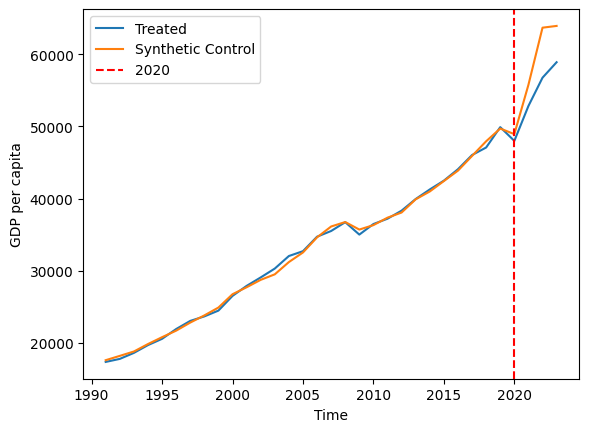

In [20]:
# Plot two lines, one for each column
sns.lineplot(x=result.index, y=result['Treated'], label='Treated')
sns.lineplot(x=result.index, y=result['Synthetic Control'], label='Synthetic Control')

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('GDP per capita')
plt.axvline(x=2020, color='red', linestyle='--', label='2020')
plt.legend()

plt.show()
